# Packages, Libraries, and Constants
- Different packages, Libraries

- Different constants and parameters

# Path to the datasets

1. Wake-word (WW) Dataset
 - `no_gaali` - `gaali`

2. Datasets
- `Augmented train data` - `Original train data` - `Test data`


In [1]:
from packages.utils import *

2024-10-12 17:40:05.678487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 17:40:05.703586: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 17:40:05.711200: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 17:40:05.728773: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-12 17:40:07.100295: W tensorflow/compiler/tf2

In [2]:
from packages.data_processing import list_directory_contents

In [3]:
train_commands = list_directory_contents(ww_train_data_dir, 'Train')
test_commands = list_directory_contents(ww_test_data_dir, 'Test')

Train commands labels: ['no_gaali' 'gaali']
Test commands labels: ['no_gaali' 'gaali']


# Dataset Pre-processing

## 1. Train and validation Datasets

- `Creating the Train and Validate Datasets`

In [4]:
from packages.data_processing import create_train_val_audio_dataset

train_ds, val_ds, label_names = create_train_val_audio_dataset(ww_train_data_dir)
print(f'Labels: {label_names}')

Found 2834 files belonging to 2 classes.
Using 2268 files for training.
Using 566 files for validation.
Audio Shape: (32, 16000)
Label Shape: (32,)
Labels: ['gaali' 'no_gaali']


2024-10-12 17:40:08.523480: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 2. Test dataset

In [5]:
from packages.data_processing import create_test_audio_dataset

test_ds = create_test_audio_dataset(ww_test_data_dir)

Found 644 files belonging to 2 classes.
Audio Shape: (32, 16000)
Label Shape: (32,)


2024-10-12 17:40:08.715960: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Data Processing

- `Feature Extraction`

In [6]:
from packages.data_processing import preprocess_melspec_audio_datasets

In [7]:
train_mel_spec_ds, val_mel_spec_ds, test_mel_spec_ds = preprocess_melspec_audio_datasets(train_ds, val_ds, test_ds)

### Shape consistency

In [8]:
print(train_mel_spec_ds.element_spec)
print(val_mel_spec_ds.element_spec)
print(test_mel_spec_ds.element_spec)

(TensorSpec(shape=(None, 124, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 124, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 124, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


# Model 1

### Input shape 

In [9]:
example_spectrograms = next(iter(train_mel_spec_ds))[0]
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)

num_labels = len(label_names)
print(f'Labels {label_names}')

Input shape: (124, 128, 1)
Labels ['gaali' 'no_gaali']


In [ ]:
from packages.model import model

### Model Architecture

In [11]:
model = model(input_shape, num_labels)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 31, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,922 (445.01 KB)

 Trainable params: 113,922 (445.01 KB)

 Non-trainable params: 0 (0.00 B)

### Compile and Train the model

In [12]:
from packages.model import compile_and_train_model_ww

In [13]:
history = compile_and_train_model_ww(model, train_mel_spec_ds, val_mel_spec_ds)

Epoch 1/30


71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - accuracy: 0.7022 - loss: 0.5352 - val_accuracy: 0.9629 - val_loss: 0.1305 - learning_rate: 0.0010
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 16s 229ms/step - accuracy: 0.9463 - loss: 0.1735 - val_accuracy: 0.9594 - val_loss: 0.1039 - learning_rate: 0.0010
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 238ms/step - accuracy: 0.9398 - loss: 0.1853 - val_accuracy: 0.9876 - val_loss: 0.0468 - learning_rate: 0.0010
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 243ms/step - accuracy: 0.9637 - loss: 0.1158 - val_accuracy: 0.9876 - val_loss: 0.0403 - learning_rate: 0.0010
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 237ms/step - accuracy: 0.9800 - loss: 0.0710 - val_accuracy: 0.9894 - val_loss: 0.0405 - learning_rate: 0.0010
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 237ms/step - accuracy: 0.9858 - loss: 0.0458 - val_accuracy: 0.9894 - val_loss: 0.0390 - learning_rate: 0.0010
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 236ms/step - accuracy: 0.9873 - loss: 0.0481 - val_

### Plot Accuracy and Loss

In [14]:
from packages.model import plot_training_history

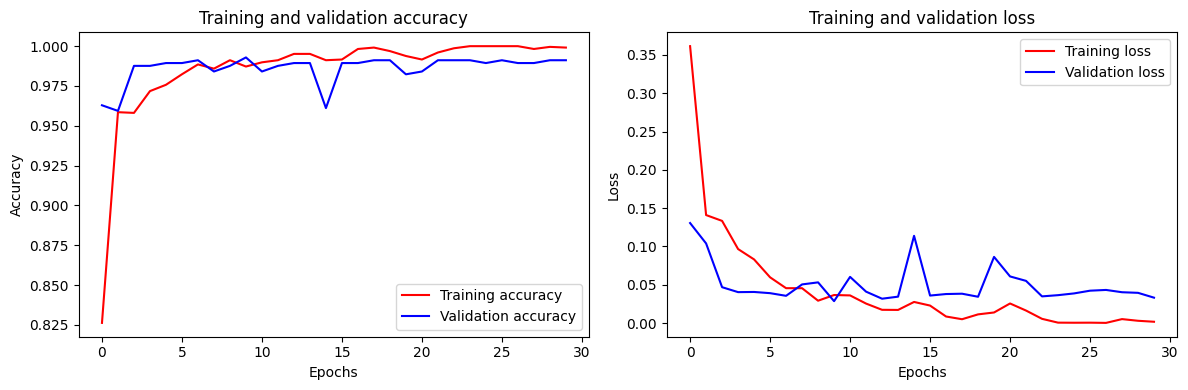

In [15]:
plot_training_history(history)

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [16]:
from packages.model import evaluate_model

In [17]:
evaluate_model(model, test_mel_spec_ds)

Test accuracy:      98%
Test loss:          0.05512494593858719
Precision:          0.9829257306339549
Recall:             0.9829192546583851
F1-score:           0.9829201204560707


## Confusion matrix

In [18]:
y_pred = model.predict(test_mel_spec_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_mel_spec_ds.map(lambda s,lab: lab)), axis=0)
label_names_slice = ['gaali', 'no_gaali']

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


2024-10-12 17:49:11.221864: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
from packages.model import plot_confusion_matrix

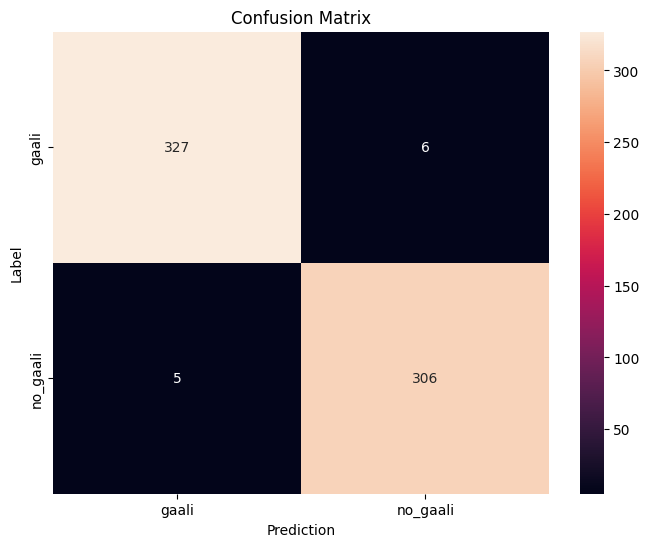

In [20]:
plot_confusion_matrix(y_true, y_pred, label_names_slice)

## save the Keras model

In [21]:
KERAS_MODEL_PATH = "model/wakeword_model_1.keras"

model.save(KERAS_MODEL_PATH)
print('Model has been successfully saved')

## Size of the model

In [ ]:
from packages.model import get_model_size

# Get the size of the trained model
keras_model_size = get_model_size(KERAS_MODEL_PATH, 'MB')

File size: 1.356 Megabytes
